Goal: Calculate necessary data for plotting

Last time everything was combined in the Rdf_to_Figures file making it unnecessarily tedious. This time, we only calculate and save necessary values and will plot it in another notebook.

In addition, the 40Hz FFR which was recorded in both sessions will be merged in section 1 and resampled in section 2. As there was no significant difference between sessions (see Merging_Sessions_Test.notebook and Checking_Merging_Sessions.rmd)

In [1]:
cd

/home/luxx0489


In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
import pickle
import mne
from scipy.stats import circmean,circvar
from sklearn import decomposition

import time

# Section 1: Interpreting vetical montage FFR

## Fig. 0 the phase topomap

In [3]:
# first we compare the reference to reveal the difference
# just using PLV and with single channel and all channels

ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
Start_trial_list = [0, 0, 1000]
End_trial_list = [2000, 1000, 2000]
output = np.empty((len(ID_list)*2*len(Freq_list),67))

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# Fz, all chan * reference

row_num = 0

for iSubject in ID_list:# range(2,18):
    
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
            epochs_H.load_data()
    
    # combine and fft
    for iRef in range(2):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:64,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:64,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:64,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:64,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            
        data = np.concatenate((data_L,data_H),0)
        
        xw_all = np.fft.rfft(np.hamming(data.shape[2])*data, axis=2)
            
        for iFreq in range(len(Freq_list)):
            
            xw = xw_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]

            plv = np.angle((xw/abs(xw)).mean(0))

            freq = np.fft.rfftfreq(data.shape[2],1/4096)

            index = np.argmin(abs(freq-Freq_list[iFreq]))

            output[row_num,0] = iSubject
            output[row_num,1] = iRef
            output[row_num,2] = Freq_list[iFreq]
            output[row_num,3:67] = plv[:,index]  #Phase of all
            
            row_num +=1

file_handle = open(folder_path + '/phase_topomap_all.obj','wb')
pickle.dump(output, file_handle)
file_handle.close()

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3272703  =      0.000 ...   799.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=T

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub12_LF/Sub12_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3321855  =      0.000 ...   811.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub12_HF/Sub12_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3411967  =      0.000 ...   833.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_eve

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub19_LF/Sub19_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3514367  =      0.000 ...   858.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub19_HF/Sub19_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3358719  =      0.000 ...   820.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_eve

## Fig. 1

In [3]:
folder_path = "./jupyter_projects/MultiChannelSSSR"
file_handle = open(folder_path +'/freq_label.obj','rb')
freq = pickle.load(file_handle)
file_handle.close()

In [4]:
# define functions (requires freq variable)

def ztransform(val, noise):
    return (val-noise.mean())/noise.std()

Target_list = [[34.28,43.43],[91.42,98.28],[233.13,217.13]]
Noise_range_list = [[20,55],[75,110],[205,240]]
Noise_index = []
for iFreq in range(3):
    index1 = np.argmin(abs(freq-Target_list[iFreq][0]))
    index2 = np.argmin(abs(freq-Target_list[iFreq][1]))
    Noise_range = np.arange(np.argmin(abs(freq-Noise_range_list[iFreq][0])),np.argmin(abs(freq-Noise_range_list[iFreq][1])))
    key1 = np.argwhere(Noise_range==index1)
    key2 = np.argwhere(Noise_range==index2)
    
    Noise_index.append(np.delete(Noise_range,[key1,key2]))

In [6]:
# first we compare the reference to reveal the difference
# just using PLV and with single channel and all channels

ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
Start_trial_list = [0, 0, 1000]
End_trial_list = [2000, 1000, 2000]
output = np.empty((len(ID_list)*2*len(Freq_list),9))

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# Fz, all chan * reference

row_num = 0

for iSubject in ID_list:# range(2,18):
    
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
            epochs_H.load_data()
    
    # combine and fft
    for iRef in range(2):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:64,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:64,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:64,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:64,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            
        data = np.concatenate((data_L,data_H),0)
        
        xw_all = np.fft.rfft(np.hamming(data.shape[2])*data, axis=2)
            
        for iFreq in range(len(Freq_list)):
            
            xw = xw_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]

            plv = abs((xw/abs(xw)).mean(0))
            mag = abs(xw).mean(0)
            
            freq = np.fft.rfftfreq(data.shape[2],1/4096)

            index = np.argmin(abs(freq-Freq_list[iFreq]))

            output[row_num,0] = iSubject
            output[row_num,1] = iRef
            output[row_num,2] = Freq_list[iFreq]
            output[row_num,3] = mag[47,index]  #Cz spectral magnitude
            output[row_num,4] = plv[47,index]  #Cz plv
            output[row_num,5] = mag[47,Noise_index[iFreq]].mean() #Fz noise floor
            output[row_num,6] = plv[47,Noise_index[iFreq]].mean() #Cz noise floor
            

            
            row_num +=1
            
    break
file_handle = open(folder_path + '/absolute_PLV_and_Mag_all.obj','wb')
pickle.dump(output, file_handle)
file_handle.close()

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3272703  =      0.000 ...   799.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=T

In [18]:
plt.(abs(xw).mean(0))

(1000, 64, 897)

(10, 240)

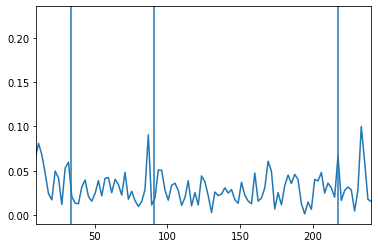

In [21]:
plt.axvline(34)
plt.axvline(91)
plt.axvline(217)
plt.plot(freq,plv[47,:])
plt.xlim(10,240)

(0, 240)

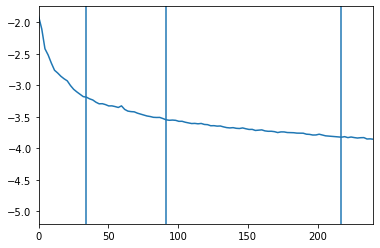

In [23]:
plt.axvline(34)
plt.axvline(91)
plt.axvline(217)
plt.plot(freq,np.log10(mag[47]))
plt.xlim(0,240)

## Fig.2 and 3: amplitude and phase of PLV at vertex and mastoids

In [13]:
# first we compare the reference to reveal the difference
# just using PLV and with single channel and all channels

ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
Start_trial_list = [0, 0, 1000, 0, 0, 1000]
End_trial_list = [2000, 1000, 2000, 2000, 1000, 2000]
output = np.empty((len(ID_list)*2*len(Freq_list),11))

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# Fz, all chan * reference

row_num = 0

for iSubject in ID_list:# range(2,18):
    
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
            epochs_H.load_data()
    
    # combine and fft
    for iRef in range(1):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            
        data = np.concatenate((data_L,data_H),0)
        linked_mastoid = data[:,64:66,:].mean(1)
        diff_horizontal = data[:,64,:] - data[:,65,:]
        vertex_channel = data[:,47,:] + data[:,46,:]
        refs = np.dstack((linked_mastoid,diff_horizontal,vertex_channel)).transpose(0,2,1)

        xw_all = np.fft.rfft(np.hamming(data.shape[2])*refs, axis=2)
        freq = np.fft.rfftfreq(data.shape[2],1/4096)  
        
        for iFreq in range(len(Freq_list)):
            
            xw = xw_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]

            plv = abs((xw/abs(xw)).mean(0))
            phase = np.angle((xw/abs(xw)).mean(0))


            index = np.argmin(abs(freq-Freq_list[iFreq]))

            output[row_num,0] = iSubject
            output[row_num,1] = Freq_list[iFreq]
            output[row_num,2:5] = plv[:,index]
            output[row_num,5:8] = phase[:,index]
            output[row_num,8:11] = plv[:,Noise_index[iFreq]].mean(1) #Fz noise floor
            
            row_num +=1

file_handle = open(folder_path + '/Fig23_location_PLV_all.obj','wb')
pickle.dump(output, file_handle)
file_handle.close()

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3272703  =      0.000 ...   799.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=T

BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3411967  =      0.000 ...   833.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub14_LF/Sub14_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3268607  =      0.000 ...   798.000 secs...
Trigger c

BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3547135  =      0.000 ...   866.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub20_HF/Sub20_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3338239  =      0.000 ...   815.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mea

# Section 2. Compare multichannel recording methods

In [59]:
# define functions (requires freq variable)

def ztransform(val, noise):
    return (val-noise.mean())/noise.std()

Target_list = [[34.28,43.43],[91.42,98.28],[233.13,217.13]]
Noise_range_list = [[20,55],[75,110],[205,240]]
Noise_index = []
for iFreq in range(3):
    index1 = np.argmin(abs(freq-Target_list[iFreq][0]))
    index2 = np.argmin(abs(freq-Target_list[iFreq][1]))
    Noise_range = np.arange(np.argmin(abs(freq-Noise_range_list[iFreq][0])),np.argmin(abs(freq-Noise_range_list[iFreq][1])))
    key1 = np.argwhere(Noise_range==index1)
    key2 = np.argwhere(Noise_range==index2)
    
    Noise_index.append(np.delete(Noise_range,[key1,key2]))

In [61]:
ID_list = [6,7,8,9,10,12,14,16,17,18,19,20,21,22]
Freq_list = [34.28, 91.42, 217.13]
sample_size = [200,400,600,800,1000]
output = np.empty((len(ID_list)*2*len(Freq_list)*len(sample_size),16))
Start_trial_list = [0, 0, 1000]
End_trial_list = [2000, 1000, 2000]

# ID, reference(0 for ave, 1 for mastoid), frequency(43.43 and 98),
# all chan plv, 
# all chan ITC,
# all chan T2,
# tPCA, cPCA

row_num = 0

for iSubject in ID_list:
    
    t = time.time()
    #load both sessions
    for file_name in ['LF','HF']:

        folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_"+ file_name +"/"
        sub_id = 'Sub' + str(iSubject) + '_' + file_name
        raw = mne.io.read_raw_bdf(folder_path + sub_id + '/' + sub_id + '_TMR0_MSK.bdf',
                                       stim_channel='Status', preload=True, exclude = ['EXG3','EXG4','EXG5','EXG6','EXG7','EXG8'])
        events = mne.find_events(raw)
        
        if file_name == 'LF':
            epochs_L = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
            epochs_L.load_data()
        else:
            epochs_H = mne.Epochs(raw,events=events, tmin=-0.5, tmax=0.5)
            epochs_H.load_data()
    
    print('loading took %s' % (time.time()-t))
    t = time.time()
    
    # combine and fft
    for iRef in range(2):
        if iRef==0:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels='average')\
            .get_data()[:,0:67,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            
        else:
            data_L = epochs_L.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            data_H = epochs_H.copy().set_eeg_reference(ref_channels=['EXG1','EXG2'])\
            .get_data()[:,0:67,int(np.round((0.5)*4096)):int(np.round((0.5+0.43752)*4096))]
            
        data_all = np.concatenate((data_L,data_H),0)
        xw_all = np.fft.rfft(np.hamming(data.shape[2])*data_all, axis=2)
        
        
        for iFreq in range(len(Freq_list)):
            
            xw_session = xw_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]
            data = data_all[Start_trial_list[iFreq]:End_trial_list[iFreq],:,:]
            
            for iSize in range(len(sample_size)):
                ind_sample = sample(range(End_trial_list[iFreq]- Start_trial_list[iFreq]),sample_size[iSize])
                xw=xw_session[ind_sample,:,:]
                
                # plv and itc
                plv = abs((xw/abs(xw)).mean(0))
                itc = abs(xw.mean(0))/(abs(xw).mean(0))
                
                # plv and itc, mean and rms
                plv_mean = plv[0:64,:].mean(0)
                itc_mean = itc[0:64,:].mean(0)
                plv_rms = np.sqrt((plv[0:64,:]**2).mean(0))
                itc_rms = np.sqrt((itc[0:64,:]**2).mean(0))
                
                print('PLV took %s' % (time.time()-t))
                t = time.time()
                
                # hotelling's t2
                out = xw[:,0:64,:]
                sample_dat = np.concatenate((np.real(out),np.imag(out)),axis=1)
                T2 = np.zeros(sample_dat.shape[2])
                
                for iBar in range(5,sample_dat.shape[2]-3):
                    batch = sample_dat[:,:,iBar].transpose(1,0)
                    S_inv = np.linalg.inv(np.cov(batch))
                    T2[iBar]=batch.mean(1) @S_inv @batch.mean(1)
                
                print('T2 took %s' % (time.time()-t))
                t = time.time()
                
                
                #cPCA and MMSC, share a loop because they both use csd
                plv_mat=np.empty((64,xw.shape[2]))
                msmc = np.empty(xw.shape[2])
                for iBar in range(max(Noise_index[2])+1):   
                    #as this section is most computationally expensive, not all bars will be calculated
                    # only those frequency bars that will be used in calculating normalized scores are used
                    # i.e. max(Noize_index)
                    
                    # cPCA
                    csd = np.matmul(xw[:,0:64,iBar].T,xw[:,0:64,iBar].conj())
                    w,v = np.linalg.eig(csd)
                    pc = np.matmul(v.conj().T,xw[:,0:64,iBar].T)
                    cplv = (pc/abs(pc)).mean(1)
                    plv_mat[:,iBar] = abs(cplv)
                
                    # MSMC
                    v_m = np.matrix(xw[:,0:64,iBar].mean(0))
                    msmc[iBar] = np.real((v_m.conj() @ np.linalg.inv(csd) @ v_m.T)[0,0])
                
                
                print('cPCA and MMSC took %s' % (time.time()-t))
                t = time.time()
                    
                    
                # concatenate and tPCA
                mix_long = np.concatenate([data[iTrial,0:64,:] for iTrial in ind_sample], axis=1)

                pca = decomposition.PCA(n_components=1)
                pca.fit(mix_long.T)
                pc_t = np.empty((sample_size[iSize],data.shape[2]))
                for iTrial in range(len(ind_sample)):
                    pc_t[iTrial,:] = pca.transform(data[ind_sample[iTrial],0:64,:].T).squeeze()
                xw_pc_t = np.fft.rfft(pc_t, axis=1)
                xw_pc_t = xw_pc_t/abs(xw_pc_t)
                plv_pc_t = abs(xw_pc_t.mean(0))
                
                print('tPCA took %s' % (time.time()-t))
                t = time.time()
                
                index = np.argmin(abs(freq-Freq_list[iFreq]))

                output[row_num,0] = iSubject
                output[row_num,1] = iRef
                output[row_num,2] = Freq_list[iFreq]
                output[row_num,3] = sample_size[iSize]
                output[row_num,4] = ztransform(plv[37,index],plv[37,Noise_index[iFreq]])
                output[row_num,5] = ztransform(itc[37,index],itc[37,Noise_index[iFreq]])
                output[row_num,6] = ztransform(plv[47,index],plv[47,Noise_index[iFreq]])
                output[row_num,7] = ztransform(itc[47,index],itc[47,Noise_index[iFreq]])
                output[row_num,8] = ztransform(plv_mean[index],plv_mean[Noise_index[iFreq]])
                output[row_num,9] = ztransform(itc_mean[index],itc_mean[Noise_index[iFreq]])
                output[row_num,10] = ztransform(plv_rms[index],plv_mean[Noise_index[iFreq]])
                output[row_num,11] = ztransform(itc_rms[index],itc_mean[Noise_index[iFreq]])
                output[row_num,12] = ztransform(T2[index],T2[Noise_index[iFreq]])
                output[row_num,13] = ztransform(plv_mat[0,index],plv_mat[0,Noise_index[iFreq]])
                output[row_num,14] = ztransform(plv_pc_t[index],plv_pc_t[Noise_index[iFreq]])
                output[row_num,15] = ztransform(msmc[index], msmc[Noise_index[iFreq]])

                row_num +=1

file_handle = open(folder_path + '/method_comparison_all.obj','wb')
pickle.dump(output, file_handle)
file_handle.close()

Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub6_LF/Sub6_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3284991  =      0.000 ...   802.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub6_HF/Sub6_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3272703  =      0.000 ...   799.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=T

tPCA took 2.5217020511627197
PLV took 2.479624032974243
T2 took 1.877533197402954
cPCA and MMSC took 2.8686602115631104
tPCA took 4.101096153259277
PLV took 3.3054378032684326
T2 took 2.0668632984161377
cPCA and MMSC took 3.681100606918335
tPCA took 5.456922292709351
PLV took 4.055425405502319
T2 took 2.524505138397217
cPCA and MMSC took 4.596811532974243
tPCA took 6.990399122238159
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
PLV took 5.769564628601074
T2 took 0.8883843421936035
cPCA and MMSC took 1.0074918270111084
tPCA took 1.1964552402496338
PLV took 1.6578500270843506
T2 took 1.262521505355835
cPCA and MMSC took 1.9940094947814941
tPCA took 2.5202677249908447
PLV took 2.4813013076782227
T2 took 1.6461634635925293
cPCA and MMSC took 2.8643882274627686
tPCA took 3.9821770191192627
PLV took 3.3074262142181396
T2 took 2.037389039993286
cPCA and MMSC took 3.754929304122925
tPC

0 bad epochs dropped
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_HF/Sub9_HF/Sub9_HF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3305471  =      0.000 ...   807.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1000 events and 4097 original time points ...
0 bad epochs dropped
loading took 23.710622549057007
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
PLV took 7.888736248016357
T2 took 0.877885103225708
cPCA and MMSC took 1.0085291862487793
tPCA too

tPCA took 1.323101282119751
PLV took 1.6606686115264893
T2 took 1.266599416732788
cPCA and MMSC took 2.010068893432617
tPCA took 2.657646417617798
PLV took 2.4817440509796143
T2 took 1.6477737426757812
cPCA and MMSC took 2.8447279930114746
tPCA took 4.1001973152160645
PLV took 3.3147969245910645
T2 took 2.071371555328369
cPCA and MMSC took 3.6599035263061523
tPCA took 5.464641094207764
PLV took 4.108928918838501
T2 took 2.5177745819091797
cPCA and MMSC took 4.517504692077637
tPCA took 7.248490810394287
PLV took 0.8642709255218506
T2 took 1.1651813983917236
cPCA and MMSC took 1.6590874195098877
tPCA took 1.3314311504364014
PLV took 1.6829195022583008
T2 took 1.6017036437988281
cPCA and MMSC took 3.1546599864959717
tPCA took 2.8025481700897217
PLV took 2.491445302963257
T2 took 2.0330557823181152
cPCA and MMSC took 4.505439281463623
tPCA took 4.21605920791626
PLV took 3.3134491443634033
T2 took 2.5464577674865723
cPCA and MMSC took 5.738323926925659
tPCA took 5.869431734085083
PLV took 4

0 bad epochs dropped
loading took 24.535949230194092
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
PLV took 8.121512413024902
T2 took 1.1660308837890625
cPCA and MMSC took 1.6036920547485352
tPCA took 1.2548840045928955
PLV took 1.685356616973877
T2 took 1.5642132759094238
cPCA and MMSC took 3.1156625747680664
tPCA took 2.779999017715454
PLV took 2.4826316833496094
T2 took 2.0551297664642334
cPCA and MMSC took 4.460598707199097
tPCA took 4.205838441848755
PLV took 3.3218741416931152
T2 took 2.535355567932129
cPCA and MMSC took 5.742271423339844
tPCA took 5.8428144454956055
PLV took 4.030951738357544
T2 took 3.2879862785339355
cPCA and MMSC took 7.013438701629639
tPCA took 7.139000177383423
PLV took 0.8652632236480713
T2 took 1.1340365409851074
cPCA and MMSC took 1.6172046661376953
tPCA took 1.2123570442199707
PLV took 1.68

PLV took 1.6881334781646729
T2 took 1.5770034790039062
cPCA and MMSC took 3.1300158500671387
tPCA took 2.5705182552337646
PLV took 2.479715585708618
T2 took 2.0161359310150146
cPCA and MMSC took 4.408098220825195
tPCA took 4.1636435985565186
PLV took 3.210684061050415
T2 took 2.1066019535064697
cPCA and MMSC took 3.773752212524414
tPCA took 5.67389178276062
PLV took 4.152459383010864
T2 took 3.17319393157959
cPCA and MMSC took 7.090635538101196
tPCA took 7.43284010887146
PLV took 0.8672881126403809
T2 took 1.1292951107025146
cPCA and MMSC took 1.6103224754333496
tPCA took 1.2590086460113525
PLV took 1.6877825260162354
T2 took 1.579946756362915
cPCA and MMSC took 3.0687687397003174
tPCA took 2.6267871856689453
PLV took 2.5021986961364746
T2 took 2.0778486728668213
cPCA and MMSC took 4.416391611099243
tPCA took 4.301131248474121
PLV took 3.312803030014038
T2 took 2.0942060947418213
cPCA and MMSC took 4.894149303436279
tPCA took 5.6648335456848145
PLV took 4.14065408706665
T2 took 2.81643

tPCA took 4.217448711395264
PLV took 3.2391233444213867
T2 took 2.5866808891296387
cPCA and MMSC took 5.742833375930786
tPCA took 5.8229453563690186
PLV took 4.007447004318237
T2 took 3.2888240814208984
cPCA and MMSC took 7.165966749191284
tPCA took 7.201054573059082
PLV took 0.8658356666564941
T2 took 1.1571812629699707
cPCA and MMSC took 1.6830334663391113
tPCA took 1.279348373413086
PLV took 1.6849141120910645
T2 took 1.5969338417053223
cPCA and MMSC took 3.136155843734741
tPCA took 2.7913498878479004
PLV took 2.468601942062378
T2 took 2.036686658859253
cPCA and MMSC took 4.502460241317749
tPCA took 4.401750802993774
PLV took 3.30340576171875
T2 took 2.546576738357544
cPCA and MMSC took 5.785064697265625
tPCA took 5.849809408187866
PLV took 4.128662109375
T2 took 3.1233129501342773
cPCA and MMSC took 7.053112268447876
tPCA took 7.053883790969849
PLV took 0.8670017719268799
T2 took 1.1503121852874756
cPCA and MMSC took 1.6687781810760498
tPCA took 1.2635111808776855
PLV took 1.685223

PLV took 1.6858704090118408
T2 took 1.5911920070648193
cPCA and MMSC took 3.1732678413391113
tPCA took 2.759392738342285
PLV took 2.4967565536499023
T2 took 2.1637511253356934
cPCA and MMSC took 4.526677370071411
tPCA took 4.159852504730225
PLV took 3.3205292224884033
T2 took 2.5682804584503174
cPCA and MMSC took 5.759161472320557
tPCA took 5.851938486099243
PLV took 4.142215251922607
T2 took 3.044785499572754
cPCA and MMSC took 6.972671985626221
tPCA took 7.075961351394653
Extracting EDF parameters from /home/luxx0489/jupyter_projects/MultiChannelSSSR/EEG_data_40_100_200Hz_LF/Sub20_LF/Sub20_LF_TMR0_MSK.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3547135  =      0.000 ...   866.000 secs...
Trigger channel has a non-zero initial value of 130944 (consider using initial_event=True to detect this event)
1000 events found
Event IDs: [65409 65410]
1000 matching events found
Applying baseline correction (mode: mean)
Not setting metad

tPCA took 4.37510085105896
PLV took 3.3190085887908936
T2 took 2.5770790576934814
cPCA and MMSC took 5.6631505489349365
tPCA took 5.829495668411255
PLV took 4.144946336746216
T2 took 2.9788150787353516
cPCA and MMSC took 7.044711589813232
tPCA took 7.149508714675903
PLV took 0.8658936023712158
T2 took 1.1687710285186768
cPCA and MMSC took 1.648601770401001
tPCA took 1.4585082530975342
PLV took 1.6843037605285645
T2 took 1.6187660694122314
cPCA and MMSC took 3.1550207138061523
tPCA took 2.790088415145874
PLV took 2.456298828125
T2 took 2.0757038593292236
cPCA and MMSC took 4.4199254512786865
tPCA took 4.192454099655151
PLV took 3.3246028423309326
T2 took 2.5496826171875
cPCA and MMSC took 5.709292650222778
tPCA took 5.977010488510132
PLV took 4.143763542175293
T2 took 2.568056344985962
cPCA and MMSC took 4.587541341781616
tPCA took 7.256130218505859
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custo